# Introduction

Notebook to analyze the **False Negatives** Results for each model in the context of traceability between **test cases** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.tc_br_models_runner import TC_BR_Runner
from modules.utils import model_evaluator as m_eval
from modules.utils import aux_functions
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = TC_BR_Runner()

lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle=fd.Tc_BR_Oracles.read_oracle_volunteers_df()

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

TestCases.shape: (195, 12)
SelectedBugReports.shape: (91, 18)
Running LSI Model ------
Running LDA Model -----
Running BM25 Model -----
Running W2V Model ------
OracleVolunteers.shape: (195, 91)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
testcases['tokens'] = testcases.apply(lambda row : tokenizer.__call__(row['tc_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,30.77,2.25,4.12,precision recall fscore ...,0.0,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
1,lsi,top_1_cosine_0.1,30.77,2.25,4.12,precision recall fscore ...,0.1,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
2,lsi,top_1_cosine_0.2,30.77,2.25,4.12,precision recall fscore ...,0.2,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
3,lsi,top_1_cosine_0.3,30.77,2.25,4.12,precision recall fscore ...,0.3,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
4,lsi,top_1_cosine_0.4,30.77,2.25,4.12,precision recall fscore ...,0.4,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...


### Grouping Results by Model

#### Min Recall

model
bm25          1.86
lda           0.37
lsi           0.59
wordvector    0.48
Name: perc_recall, dtype: float64



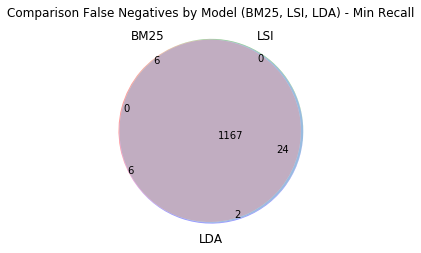

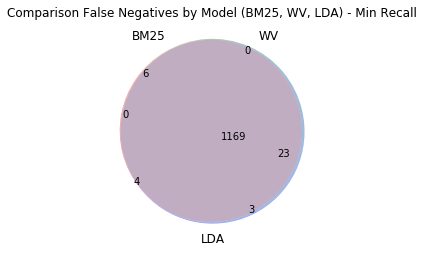

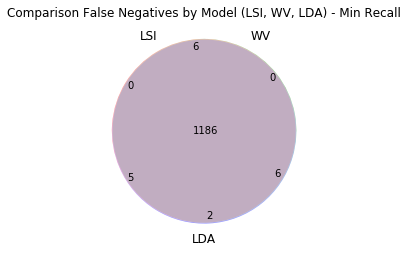

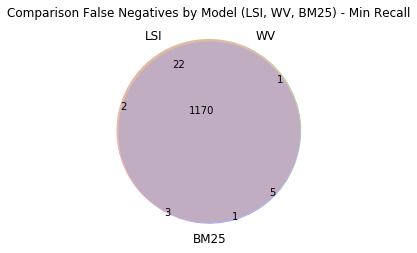

In [6]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Recall')
plt.show()

##### Exclusive Cases

In [7]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


set()



LDA Exclusive FN:


{('TC_105_TRG', 'BR_1300738_SRC')}



WV Exclusive FN:


set()

#### Max Recall

model
bm25          14.20
lda           13.29
lsi           23.46
wordvector     3.66
Name: perc_recall, dtype: float64



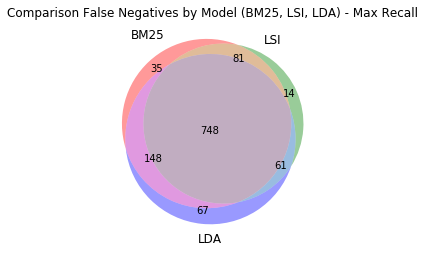

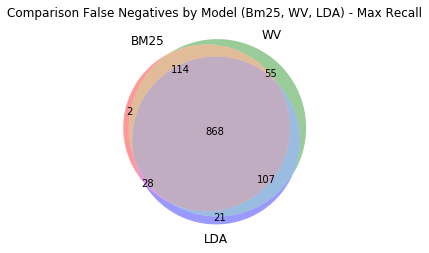

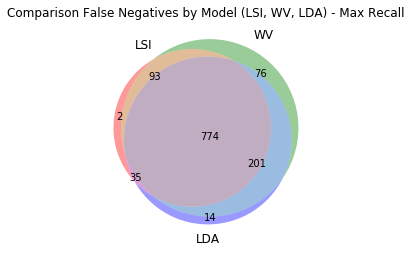

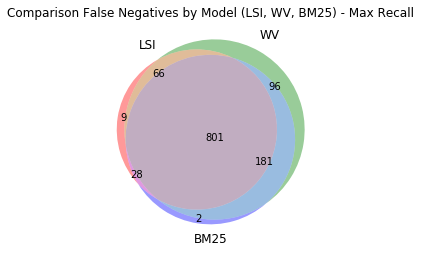

In [8]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [9]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FN:
len(bm25_exc_set): 0


LSI Exclusive FN:
len(lsi_exc_set): 0


LDA Exclusive FN:
len(lda_exc_set): 12


WV Exclusive FN:
len(wv_exc_set): 41


##### Word Clouds

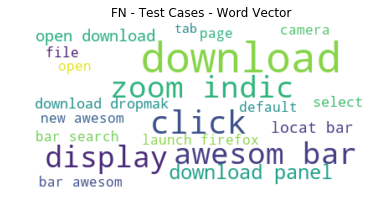

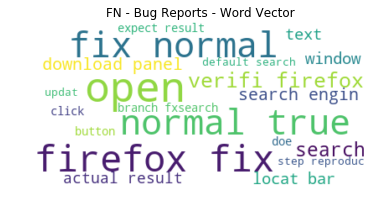

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [10]:
aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - Word Vector",
                                    wc_br_title="FN - Bug Reports - Word Vector")

aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - BM25",
                                    wc_br_title="FN - Bug Reports - BM25")

aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - LSI",
                                    wc_br_title="FN - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - LDA",
                                    wc_br_title="FN - Bug Reports - LDA")


In [ ]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

##### Detailing Features for Exclusive Sets

In [ ]:
aux_functions.detail_features(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features(wv_exc_set, bugreports=bugreports, testcases=testcases)

#### Min Precision

In [ ]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

In [ ]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

#### Max Precision

In [ ]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

In [ ]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))